## Import Python packages

In [1]:
import calendar
import os
import sys
import time

## Import data analysis, machine learning, and visualization packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf

from numpy.random import default_rng

print(f"TensorFlow version:{tf.__version__}")
print(f"Matplotlib version:{matplotlib.__version__}")

TensorFlow version:2.16.1
Matplotlib version:3.7.2


## Import methods from OEDI data imputation module

In [3]:
baseDir=os.path.dirname(os.path.dirname((os.path.dirname(os.getcwd())))) #Add path of working directory e.g.'/home/splathottam/GitHub/oedi'
print(f"Adding base directory:{baseDir} to path")
sys.path.insert(0,baseDir) #Add module path to prevent import errors

from datapreprocessor.datapreprocessor.app.nodeload.nodeload_utilities import plot_distribution,get_downsampled_df
from datapreprocessor.datapreprocessor.app.nodeload.datapipeline_utilities import get_train_test_eval_timesteps,df_to_input_target_dataset
from datapreprocessor.datapreprocessor.app.nodeload.pmu_preprocessing import pmu_to_timeseries,generate_node_voltage_profiles


from datapreprocessor.datapreprocessor.app.dataimputation.data_imputation_preprocessing import get_df_for_training_from_timesteps,get_knn_array
from datapreprocessor.datapreprocessor.app.dataimputation.data_imputation_postprocessing import compare_performance_moving_window,evaluate_dataimputation_on_streaming_data_multi_nodes
from datapreprocessor.datapreprocessor.app.dataimputation.model_utilities import get_knn_imputer_predictions,get_knn_imputer
from datapreprocessor.datapreprocessor.app.model_utilities.model_utilities import get_autoencoder_model,get_compiled_model,get_checkpoint_callback,get_normalizer,evaluate_predict
from datapreprocessor.datapreprocessor.app.model_utilities.model_training_utilities import train_model,get_best_model
from datapreprocessor.datapreprocessor.app.model_utilities.model_save_load_utilities import model_to_archive,load_keras_model


rng = default_rng()

Adding base directory:c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor to path


## Highlevel block diagram of datapreprocessing module

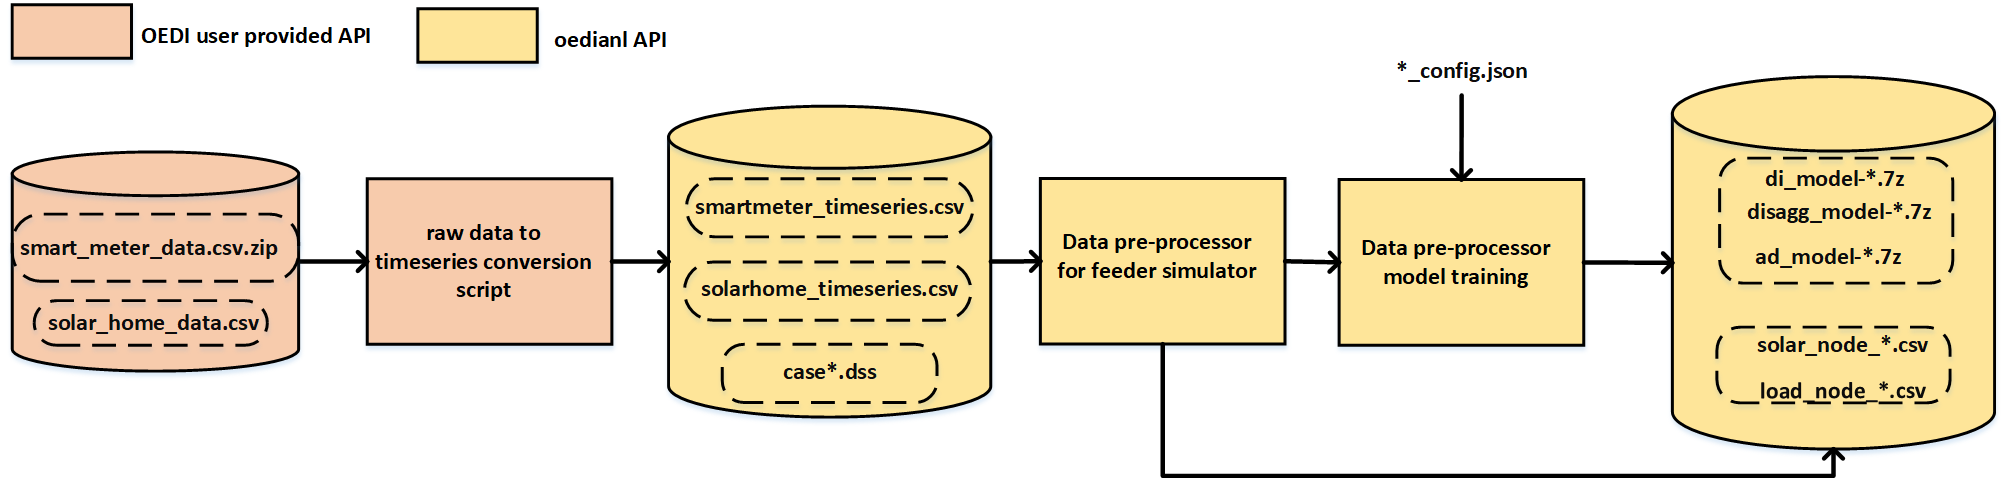

## Specify locations of time series data

In [4]:
folder_name_pmu = os.path.join(baseDir,"datapreprocessor","datapreprocessor","data","pmu")
folder_name_plots = os.path.join(baseDir,"datapreprocessor","datapreprocessor","app","dataimputation","plots")
csv_file_pmu_raw = "pmu_data_sample_large.csv"

## Raw PMU data

In [6]:
df_test = pd.read_csv(os.path.join(folder_name_pmu,csv_file_pmu_raw)) #pmu_data_sample
df_test.head()

,FDRID,TimeStamp,Conv,ReceivedTime,Frequency,Voltage _Ang,Voltage _Mag,POWV000,POWV001,POWV002,...,Ana4590,Ana4591,Ana4592,Ana4593,Ana4594,Ana4595,Ana4596,Ana4597,Ana4598,Ana4599
0,26,2023-09-05 23:59:48,9,2023-09-06 00:00:00.018,59.996994,6.224699,906544.0,16911,20619,-15704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,2023-09-05 23:59:48,10,2023-09-06 00:00:00.096,59.997780,6.223071,906544.0,16911,20619,-15704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26,2023-09-05 23:59:49,1,2023-09-06 00:00:00.237,59.996544,6.221638,906544.0,16911,20619,-15704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26,2023-09-05 23:59:49,2,2023-09-06 00:00:00.377,59.997635,6.219715,906544.0,16911,20619,-15704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26,2023-09-05 23:59:49,3,2023-09-06 00:00:00.455,59.996708,6.217995,906544.0,16911,20619,-15704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Converter raw PMU data to time series PMU data

In [6]:
df = pmu_to_timeseries(os.path.join(folder_name_pmu,csv_file_pmu_raw),datetime_column = "datetime",id_column = "fdrid",save_folder = folder_name_pmu)
df.head()

Found following 1 ids:[26]
Saving pmu time series in c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\data\pmu\pmu_n_pmu-1_n_days-2.csv


,datetime,vmag_pmu_26_1,vang_pmu_26_1
0,2023-09-05 23:59:48.800,906544.0,6.224699
1,2023-09-05 23:59:48.900,906544.0,6.223071
2,2023-09-05 23:59:49.000,906544.0,6.221638
3,2023-09-05 23:59:49.100,906544.0,6.219715
4,2023-09-05 23:59:49.200,906544.0,6.217995


## Select timeseries file for use as base file

In [7]:
selected_timeseries_files  = ["pmu_n_pmu-1_n_days-2.csv"] #Specify file containing pmu data
selected_timeseries_files = [os.path.join(folder_name_pmu,timeseries_file) for timeseries_file in selected_timeseries_files]
print(selected_timeseries_files)

['c:\\Users\\splathottam\\Box Sync\\GitHub\\oedi-si-single-container\\build\\datapreprocessor\\datapreprocessor\\datapreprocessor\\data\\pmu\\pmu_n_pmu-1_n_days-2.csv']


## Exploration on time series file

In [8]:
df_timeseries_downsampled = get_downsampled_df(df,datetime_column="datetime",downsample_time_period="5S") #1S = 1 second, 5T = 5 minutes
df_timeseries_downsampled["vmag_pmu_26_1"]=df_timeseries_downsampled["vmag_pmu_26_1"]/1000 #Convert volts to kV
df_timeseries_downsampled.head(n=20)

Original time period:0.1 seconds
Original time period:0 minutes
After downsampling...
Original time period:5.0 seconds
Original time period:0 minutes


,datetime,vmag_pmu_26_1,vang_pmu_26_1
block_index,,,
0,2023-09-05 23:59:45,906.54400,6.213164
1,2023-09-05 23:59:50,906.54400,6.042971
2,2023-09-05 23:59:55,906.54458,5.593447
3,2023-09-06 00:00:00,906.54500,5.041403
4,2023-09-06 00:00:05,906.54666,4.395734
5,2023-09-06 00:00:10,906.54700,3.670935
6,2023-09-06 00:00:15,906.54748,2.932242
7,2023-09-06 00:00:20,906.54800,2.229893
8,2023-09-06 00:00:25,906.54946,1.559274


In [9]:
df_timeseries_downsampled.describe()

,datetime,vmag_pmu_26_1,vang_pmu_26_1
count,4321,4321.000000,4321.000000
mean,2023-09-06 02:59:44.999999744,908.123678,4.086117
min,2023-09-05 23:59:45,906.544000,1.050657
25%,2023-09-06 01:29:45,907.333260,2.684544
50%,2023-09-06 02:59:45,908.123300,4.052197
75%,2023-09-06 04:29:45,908.914000,5.500402
max,2023-09-06 05:59:45,909.704000,7.214713
std,NaN,0.912782,1.646318


Number of elements in dataframe:4321
Saving figure in plots\vmag_histogram....


c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\nodeload\nodeload_utilities.py:623: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[column_name], hist = False, kde = True,


<Axes: title={'center': 'vmag_histogram-4321 samples'}, xlabel='vmag_pmu_26_1', ylabel='Density'>

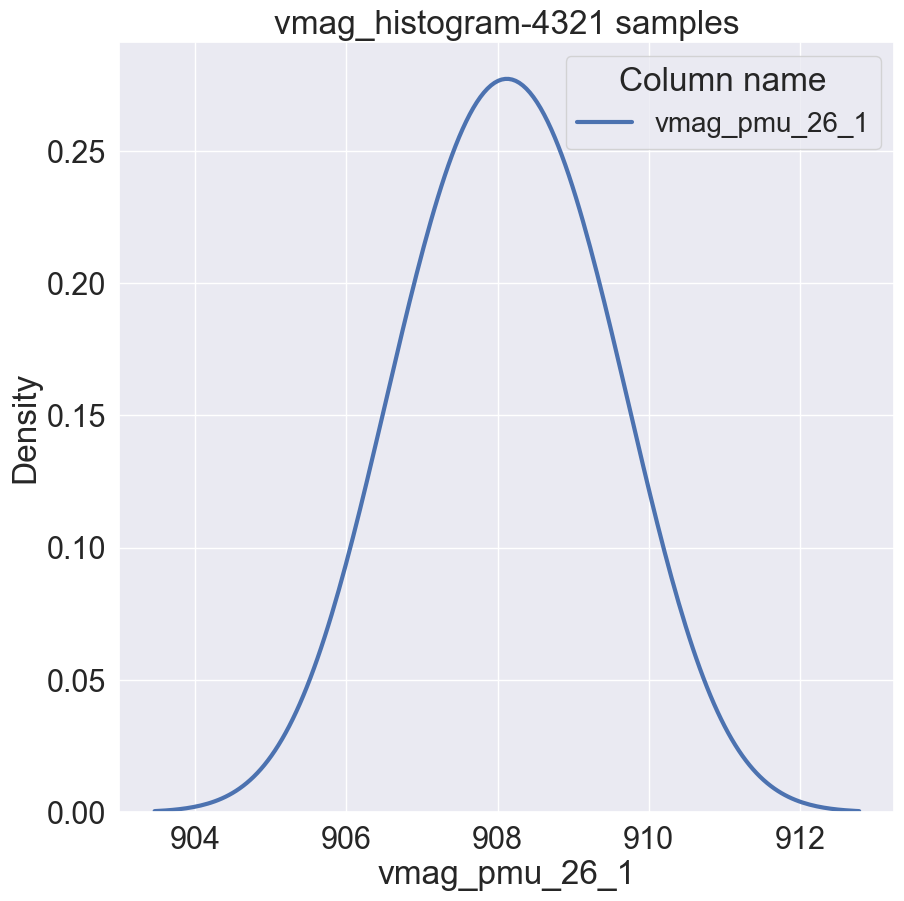

In [10]:
plot_distribution(df_timeseries_downsampled,column_names= ["vmag_pmu_26_1"],plot_type='density', fig_size=(10, 10),plot_folder='plots',plot_title='vmag_histogram',show_plot=True,show_means=True,font_size=16,line_styles={},kde_kws = {'linewidth': 3,'bw_adjust':6},y_label = "Value")


Number of elements in dataframe:4321
Saving figure in plots\vangle_distribution....


c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\nodeload\nodeload_utilities.py:623: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df[column_name], hist = False, kde = True,


<Axes: title={'center': 'vangle_distribution-4321 samples'}, xlabel='vang_pmu_26_1', ylabel='Density'>

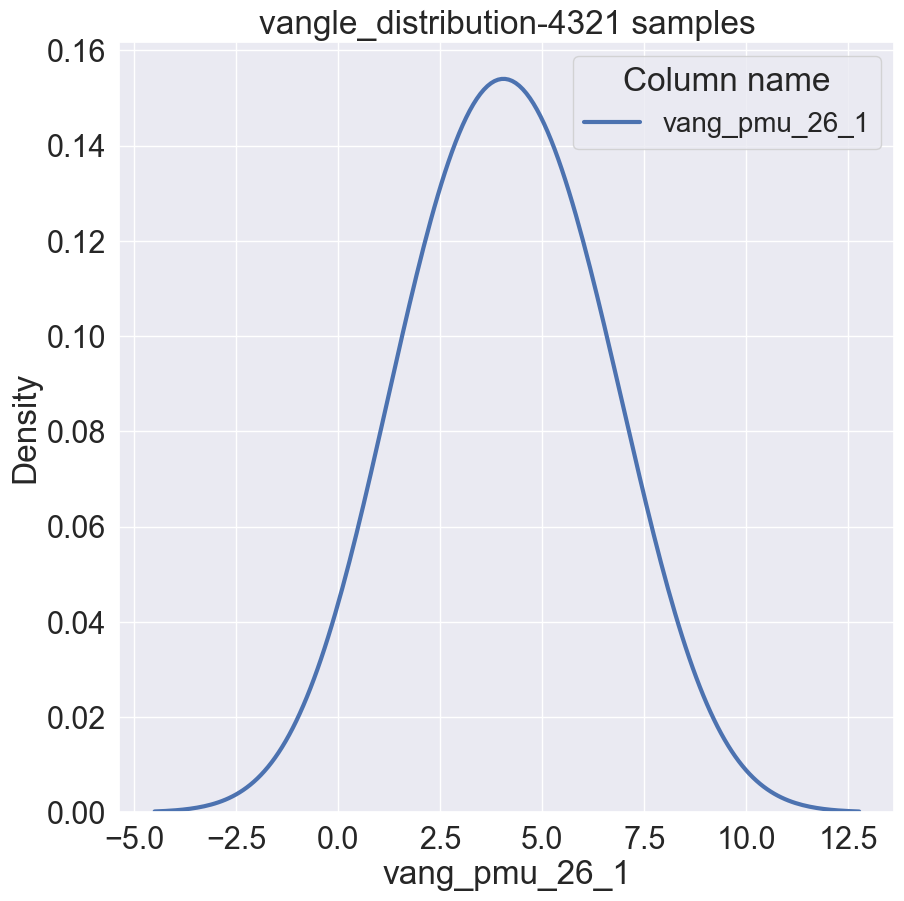

In [11]:
plot_distribution(df_timeseries_downsampled,column_names= ["vang_pmu_26_1"],plot_type='density', fig_size=(10, 10),plot_folder='plots',plot_title='vangle_distribution',show_plot=True,show_means=True,font_size=16,line_styles={},kde_kws = {'linewidth': 3,'bw_adjust':6},y_label = "Value")


## Specify details of anonymized node voltage profiles

In [12]:
selected_month = 2 # The month for which we developing the profiles
n_days = 2 # The number of days for which we are generating the profiles

## Generate anonymized node load profiles for the slected distribution system model

In [13]:
df_node_voltage,node_voltage_dict = generate_node_voltage_profiles(df,n_days=n_days,start_year = 2016,start_month=selected_month,start_day=1)
df_node_voltage.head()

Creating node voltage profiles for year:2016,month:2
Number of time steps per day:215973
Time interval in minutes:0 min
Time interval in minutes:0 min
Found following 1 pmu IDs:['26_1']


,datetime,node_1
0,2023-09-05 23:59:48.800,906544.0
1,2023-09-05 23:59:48.900,906544.0
2,2023-09-05 23:59:49.000,906544.0
3,2023-09-05 23:59:49.100,906544.0
4,2023-09-05 23:59:49.200,906544.0


## Visualize anonymized node load profiles

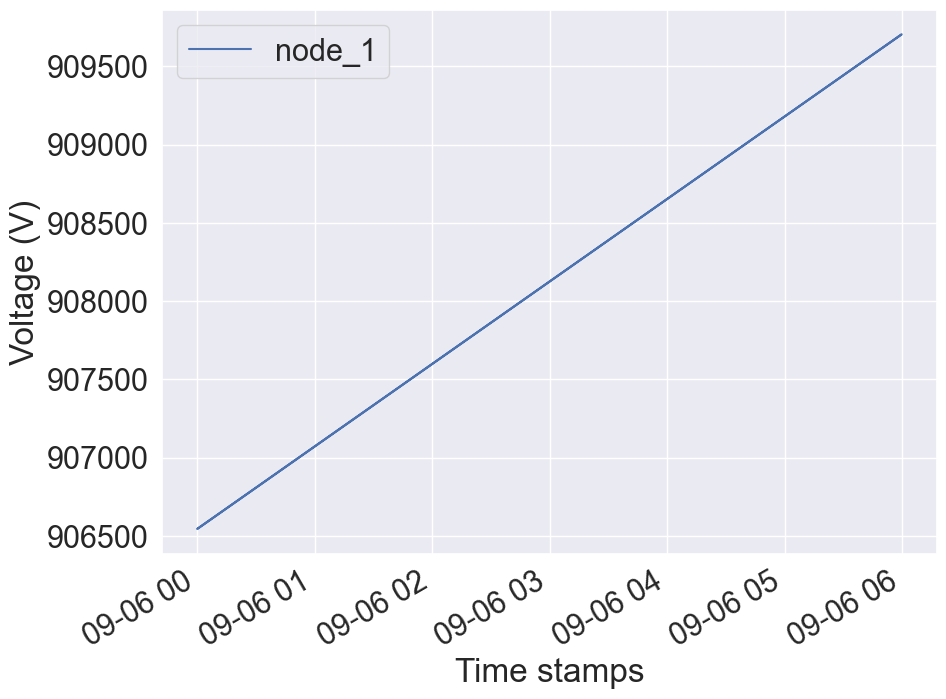

In [14]:
node_choices =list(rng.choice(list(node_voltage_dict.keys()),size = 1,replace=False))
df_node_voltage.plot(x = "datetime",y =node_choices,xlabel='Time stamps', ylabel='Voltage (V)',figsize=(10,8)).get_figure().savefig(f"nodevoltage.png")


## Training data specifications

In [15]:
missing_fraction = 0.05 #The minimum fraction of values that will be missing in the training data
consecutive_missing = True #Should consecutive values be missing
consequtive_missing_probabilities = {"two":{"conditional_probability":0.2},
                                        "three":{"conditional_probability":0.1},
                                        "four":{"conditional_probability":0.05}}
replacement_methods=["ffill"]#,"bfill","mean","median","LI"]
cyclical_features = ["hour_of_day",'day_of_week','weekend'] #Cyclical features to be added to the training data

## Specify train and test nodes

In [16]:
selected_train_timestamps,selected_test_timestamps,selected_eval_timestamps = get_train_test_eval_timesteps(df_node_voltage["datetime"].values,train_fraction=0.75,test_fraction=0.2)

Total train samples:153880
Total test samples:51294
Total eval samples:10799
Train samples:153880,Test nodes:51294,Eval nodes:10799


## Generate training and testing data

In [17]:
measurement_column = "voltage_value"
df_train = get_df_for_training_from_timesteps(df_node_voltage,selected_train_timestamps,measurement_column,cyclical_features,missing_fraction,multi_corruption=consecutive_missing,consequtive_corruption_probabilities=consequtive_missing_probabilities,replacement_methods=replacement_methods)
df_test = get_df_for_training_from_timesteps(df_node_voltage,selected_test_timestamps,measurement_column,cyclical_features,missing_fraction,multi_corruption=consecutive_missing,consequtive_corruption_probabilities=consequtive_missing_probabilities,replacement_methods=replacement_methods)
#df_train[df_train["corruption_encoding"]==1]

n_train_samples = len(df_train)

Selecting 153880 for creating a dataframe to use for training...


100%|██████████| 1/1 [00:00<00:00, 67.02it/s]


Encoding cyclical feature:hour_of_day
Encoding cyclical feature:day_of_week
Encoding cyclical feature:weekend
Probability of atleast one missing value:0.05
Probability of two consequtive missing values:0.0100
Probability of three consequtive missing values:0.0010
Probability of four consequtive missing values:0.0001


100%|██████████| 153880/153880 [00:02<00:00, 64062.68it/s]


Event at least one count:7649
Event probability:one:0.0497
Event at least two count:1483
Event probability:two:0.0096
Event at least three count:155
Event probability:three:0.0010
Event at least four count:10
Event probability:four:0.0001
Total missing value events:9297
Number of corrupted values time stamps:9297
FIlling NAN values using ffill...
Selecting 51294 for creating a dataframe to use for training...


100%|██████████| 1/1 [00:00<00:00, 250.50it/s]


Encoding cyclical feature:hour_of_day
Encoding cyclical feature:day_of_week
Encoding cyclical feature:weekend
Probability of atleast one missing value:0.05
Probability of two consequtive missing values:0.0100
Probability of three consequtive missing values:0.0010
Probability of four consequtive missing values:0.0001


100%|██████████| 51294/51294 [00:00<00:00, 63496.42it/s]

Event at least one count:2486
Event probability:one:0.0485
Event at least two count:501
Event probability:two:0.0098
Event at least three count:53
Event probability:three:0.0010
Event at least four count:4
Event probability:four:0.0001
Total missing value events:3044
Number of corrupted values time stamps:3044
FIlling NAN values using ffill...


## Data imputation model details

In [26]:
window_size =  4 #The lenghth of the time window
model_type = "lstm" #"1dcnn"#"lstm" #Currently enther lstm or 1dcnn
batch_size = 32 #Batch size used for training
n_epochs =  3 #Number of epochs to train
monitored_metric = "val_loss"#"val_mean_absolute_error" # Performance metric monitored during training
model_checkpoint_folder = os.path.join(baseDir,"datapreprocessor","datapreprocessor","app","dataimputation","model_checkpoints","pmu",f'month_{calendar.month_abbr[selected_month]}')
model_archive_folder = os.path.join(baseDir,"datapreprocessor","datapreprocessor","app","dataimputation","saved_models")

model_identifier = "vpmutest"

## Input features for data imputation model

In [19]:
encoded_cyclical_features= ['cos_hour','sin_hour']#,'cos_day_of_week','sin_day_of_week','weekend']
auxiliary_features = [f'{measurement_column}_corrupted_ffill']#,'load_value_corrupted_bfill','load_value_corrupted_LI']

input_features = [f"{measurement_column}_corrupted"] + auxiliary_features  + ["corruption_encoding"]  + encoded_cyclical_features
target_feature =  f"{measurement_column}"
n_input_features = len(input_features)
n_output_features =  1
print(f"Using following {n_input_features} features as input to data imputation model:{input_features}")

Using following 5 features as input to data imputation model:['voltage_value_corrupted', 'voltage_value_corrupted_ffill', 'corruption_encoding', 'cos_hour', 'sin_hour']


## Convert dataframe into a dataset object that can be used by model training

In [20]:
train_input_target = df_to_input_target_dataset(df_train,window_size,input_features,target_feature,batch_size,use_prefetch=True,df_type = "train")
test_input_target = df_to_input_target_dataset(df_test,window_size,input_features,target_feature,batch_size,use_prefetch=True,df_type = "test")

First two elements in train dataset:(array([[ 9.0654400e+05,  9.0654400e+05,  0.0000000e+00,  1.0000000e+00,
        -2.4492936e-16],
       [ 9.0654400e+05,  9.0654400e+05,  0.0000000e+00,  1.0000000e+00,
        -2.4492936e-16],
       [ 9.0654400e+05,  9.0654400e+05,  0.0000000e+00,  1.0000000e+00,
        -2.4492936e-16],
       [ 9.0654400e+05,  9.0654400e+05,  0.0000000e+00,  1.0000000e+00,
        -2.4492936e-16]]), array([906544., 906544., 906544., 906544.]))
Checking moving window for window size 4 with input features:['voltage_value_corrupted', 'voltage_value_corrupted_ffill', 'corruption_encoding', 'cos_hour', 'sin_hour'] on 10 samples.
No difference detected!
TF train dataset Cardinality:153877 - df size:153880
NAN in train:False
First two elements in test dataset:(array([[9.08795000e+05, 9.08795000e+05, 0.00000000e+00, 4.60065038e-01,
        8.87885218e-01],
       [9.08795000e+05, 9.08795000e+05, 0.00000000e+00, 4.60065038e-01,
        8.87885218e-01],
       [9.08795000

## Create object to normalize data

In [21]:
normalizer = get_normalizer(df_train,input_features,skip_normalization=encoded_cyclical_features+["corruption_encoding"]) #Obtain a normalizer using training data
print(f"Raw data:{test_input_target.take(1).as_numpy_iterator().next()[0][0:2]}")
print(f"Normalized data:{normalizer(test_input_target.take(1).as_numpy_iterator().next()[0][0:2])}")

Adding mean and vars for voltage_value_corrupted
Adding mean and vars for voltage_value_corrupted_ffill
Adding identities for corruption_encoding
Adding identities for cos_hour
Adding identities for sin_hour
Means:[852830.2102027554, 907669.5974460619, 0, 0, 0], Vars:[46768911501.592995, 422760.20446452283, 1, 1, 1]
Raw data:[[[9.08795000e+05 9.08795000e+05 0.00000000e+00 4.60065038e-01
   8.87885218e-01]
  [9.08795000e+05 9.08795000e+05 0.00000000e+00 4.60065038e-01
   8.87885218e-01]
  [9.08795000e+05 9.08795000e+05 0.00000000e+00 4.60065038e-01
   8.87885218e-01]
  [9.08795000e+05 9.08795000e+05 0.00000000e+00 4.60065038e-01
   8.87885218e-01]]

 [[9.08795000e+05 9.08795000e+05 0.00000000e+00 4.60065038e-01
   8.87885218e-01]
  [9.08795000e+05 9.08795000e+05 0.00000000e+00 4.60065038e-01
   8.87885218e-01]
  [9.08795000e+05 9.08795000e+05 0.00000000e+00 4.60065038e-01
   8.87885218e-01]
  [0.00000000e+00 9.08795000e+05 1.00000000e+00 4.60065038e-01
   8.87885218e-01]]]
Normalized da

## Create data imputation model

In [22]:
di_model = get_autoencoder_model(model_type,window_size,n_input_features,n_output_features,normalizer=normalizer)
di_model = get_compiled_model(di_model)

Selecting autoencoder model type:lstm
Returning model of type:<class 'datapreprocessor.datapreprocessor.app.model_utilities.models.LSTMAutoEncoder'>
Compiling model using Keras backend:tensorflow...


Model: "lstm_auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ sequential (Sequential)     │ ?                     │     42,400 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ normalization          │ (None, 4, 5)          │          0 │   -   │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ lstm (LSTM)            │ (None, 100)           │     42,400 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ sequential_1 (Sequential)   │ ?                     │          0 │   -   │
│                             │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ repeat_vector          │ ?                     │          0 │   -   │
│ (RepeatVector)              │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ lstm_1 (LSTM)          │ ?                     │          0 │   -   │
│                             │                       │  (unbuilt) │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ time_distributed       │ ?                     │          0 │   -   │
│ (TimeDistributed)           │                       │  (unbuilt) │       │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 42,400 (331.25 KB)

 Trainable params: 42,400 (331.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_checkpoint_file = 'di_model.epoch{epoch:02d}-loss{val_loss:.5f}' #'-mae{val_mean_absolute_error:.5f}'
model_checkpoint_path=os.path.join(model_checkpoint_folder,f'm-{calendar.month_abbr[selected_month]}_w-{window_size}_f-{n_input_features}_c-{missing_fraction}_n-{n_train_samples}_{model_type}_'+model_checkpoint_file)
callbacks = [get_checkpoint_callback(model_checkpoint_path,monitored_metric,save_weights_only=False)]


Creating model checkpoint at:c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\dataimputation\model_checkpoints\pmu\month_Feb\m-Feb_w-4_f-5_c-0.05_n-153880_lstm_di_model.epoch{epoch:02d}-loss{val_loss:.5f}.keras


## Train model

Training using following Keras backend:tensorflow
Epoch 1/3
4806/4809 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 73824384.0000 - mean_absolute_error: 6134.3394
Epoch 1: val_loss improved from 3120026368.00000 to 522719328.00000, saving model to c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\dataimputation\model_checkpoints\pmu\month_Feb\m-Feb_w-4_f-5_c-0.05_n-153880_lstm_di_model.epoch01-loss522719328.00000.keras
4809/4809 ━━━━━━━━━━━━━━━━━━━━ 73s 15ms/step - loss: 73857288.0000 - mean_absolute_error: 6135.2939 - val_loss: 522719328.0000 - val_mean_absolute_error: 18964.2949
Epoch 2/3
4807/4809 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 556458752.0000 - mean_absolute_error: 10620.5000
Epoch 2: val_loss improved from 522719328.00000 to 440552384.00000, saving model to c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\dataimputation\model_chec

Model: "lstm_auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ sequential (Sequential)     │ ?                     │     42,400 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ normalization          │ (None, 4, 5)          │          0 │   -   │
│ (Normalization)             │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ lstm (LSTM)            │ (None, 100)           │     42,400 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ sequential_1 (Sequential)   │ ?                     │     80,501 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ repeat_vector          │ (None, 4, 100)        │          0 │   -   │
│ (RepeatVector)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ lstm_1 (LSTM)          │ (None, 4, 100)        │     80,400 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ time_distributed       │ (None, 4, 1)          │        101 │   Y   │
│ (TimeDistributed)           │                       │            │       │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 368,705 (2.81 MB)

 Trainable params: 122,901 (960.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,804 (1.88 MB)

Saving training history plot in plots/model_training_progress.png...


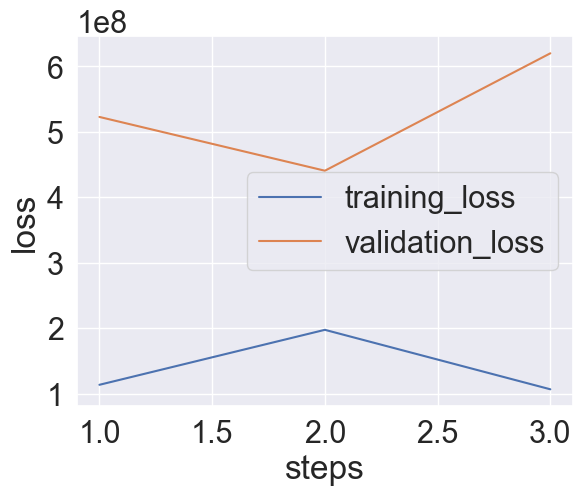

In [27]:
di_model,history = train_model(di_model,train_input_target,test_input_target,n_epochs,callbacks)


## Save best model for inference

In [28]:
best_monitored_metric,best_epoch = get_best_model(history,monitored_metric)
best_checkpoint_file = f'di_model.epoch{best_epoch:02d}-loss{best_monitored_metric:.5f}.keras'

best_model_savepath = os.path.join(model_checkpoint_folder,f'm-{calendar.month_abbr[selected_month]}_w-{window_size}_f-{n_input_features}_c-{missing_fraction}_n-{n_train_samples}_{model_type}_'+best_checkpoint_file)
best_model_archivepath = os.path.join(model_archive_folder,f'm-{calendar.month_abbr[selected_month]}_w-{window_size}_f-{n_input_features}_c-{missing_fraction}_n-{n_train_samples}_{model_type}_di_model_{model_identifier}')
print(f"Best model checkpoint:{best_model_savepath}")	
model_to_archive(best_model_savepath,best_model_archivepath)# Saved best checkpoint file which can be used by the inference script

Best model found at epoch:2 with val_loss:440552384.000000
Best model checkpoint:c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\dataimputation\model_checkpoints\pmu\month_Feb\m-Feb_w-4_f-5_c-0.05_n-153880_lstm_di_model.epoch02-loss440552384.00000.keras
Copying keras model to:c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\dataimputation\saved_models\m-Feb_w-4_f-5_c-0.05_n-153880_lstm_di_model_vpmutest


## Create data for evaluation

In [32]:
df_eval = get_df_for_training_from_timesteps(df_node_voltage,selected_eval_timestamps,measurement_column,cyclical_features,missing_fraction,multi_corruption=consecutive_missing,consequtive_corruption_probabilities=consequtive_missing_probabilities,replacement_methods=replacement_methods)
eval_input_target = df_to_input_target_dataset(df_eval,window_size,input_features,target_feature,batch_size,use_prefetch=True,df_type = "eval")

Selecting 10799 for creating a dataframe to use for training...


100%|██████████| 1/1 [00:00<?, ?it/s]

Encoding cyclical feature:hour_of_day
Encoding cyclical feature:day_of_week
Encoding cyclical feature:weekend
Probability of atleast one missing value:0.05
Probability of two consequtive missing values:0.0100
Probability of three consequtive missing values:0.0010
Probability of four consequtive missing values:0.0001


100%|██████████| 10799/10799 [00:00<00:00, 48242.43it/s]


Event at least one count:497
Event probability:one:0.0460
Event at least two count:111
Event probability:two:0.0103
Event at least three count:9
Event probability:three:0.0008
Event at least four count:2
Event probability:four:0.0002
Total missing value events:619
Number of corrupted values time stamps:619
FIlling NAN values using ffill...
First two elements in eval dataset:(array([[9.09547000e+05, 9.09547000e+05, 0.00000000e+00, 2.03456013e-01,
        9.79084088e-01],
       [9.09547000e+05, 9.09547000e+05, 0.00000000e+00, 2.03456013e-01,
        9.79084088e-01],
       [9.09547000e+05, 9.09547000e+05, 0.00000000e+00, 2.03456013e-01,
        9.79084088e-01],
       [9.09547000e+05, 9.09547000e+05, 0.00000000e+00, 2.03456013e-01,
        9.79084088e-01]]), array([909547., 909547., 909547., 909547.]))
Checking moving window for window size 4 with input features:['voltage_value_corrupted', 'voltage_value_corrupted_ffill', 'corruption_encoding', 'cos_hour', 'sin_hour'] on 10 samples.
No 

## Get imputation predictions from kNN imputation model for comparison

In [30]:
knn_array = get_knn_array(df_eval,window_size,measurement_column,n_windows = 1400000)
knn_imputer = get_knn_imputer(knn_array,n_neighbors=10)
predictions_eval_knn = get_knn_imputer_predictions(knn_imputer,knn_array)

Array shape from knn dataset:(10796, 4, 1)
Array shape after reshape:(10796, 4)
Fitting KNN imputer with 10796 samples
Predicting using KNN imputer on 10796 samples


## Evaluate model

In [34]:
best_model = load_keras_model(best_model_savepath)
predictions_eval = evaluate_predict(best_model,input_target=eval_input_target)
df_comparison_eval = compare_performance_moving_window(df_eval,predictions_eval,window_size, measurement_column,n_windows = 1400000,alternate_predictions={"knn":predictions_eval_knn})

Loading Keras model:c:\Users\splathottam\Box Sync\GitHub\oedi-si-single-container\build\datapreprocessor\datapreprocessor\datapreprocessor\app\dataimputation\model_checkpoints\pmu\month_Feb\m-Feb_w-4_f-5_c-0.05_n-153880_lstm_di_model.epoch02-loss440552384.00000.keras
Successfully loaded Keras model!
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 125010936470948737449984.0000 - mean_absolute_error: 349787160576.0000
338/338 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Model performance metrics:[1.2563917060456841e+23, 350989320192.0]
Predictions shape:(10796, 4, 1)
Taking 1400000 element from dataset with cardinality:10796 and converting to Numpy array...
Array shape from dataset:(10796, 4, 3)
Array shape after reshape:(43184,)
Adding alternate prediction:knn
Calculation imputation accuracy meterics for 2476 missing values...
MAE - ffill:0.010,DAE:289635802324.343
MSE - ffill:0.010,DAE:93777245324460257443840.000
RMSE - ffill:0.098,DAE:306230706044.414
knn - MAE:0.000,MSE::0.000,RMSE::0.008
Rel

## Use data imputation model on streaming data

In [ ]:
monitored_nodes = list(df_eval["node_id"].unique()[0:10])
evaluate_dataimputation_on_streaming_data_multi_nodes(df_eval,di_model,monitored_nodes,window_size,input_features,timeinterval_mins=15)